In [1]:
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import QuantileTransformer

# Cross-validation with hyperparameter tuning

In [38]:
data = pd.read_csv(r"hk_eui_sample_github.csv",index_col=0,encoding='ISO-8859-1')

In [44]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [45]:
log_y = np.log10(y)

In [49]:
log_y_category = pd.cut(log_y, bins=5)

In [50]:
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [51]:
#Weight adjustment
for i in range(len(log_y)):
    if log_y[i]<=1.2 or log_y[i]>2.25:
        log_y_weight[i] = log_y_weight[i]*32
    elif log_y[i]>1.70 and log_y[i]<1.90:
        log_y_weight[i] = log_y_weight[i]/16
    else:
        log_y_weight[i] = log_y_weight[i]*6

In [52]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [53]:
data_matrix = xgb.DMatrix(data=X, label=log_y, weight=log_y_weight)

In [54]:
from typing import Tuple
def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    r2_value = r2_score(y, predt)
    return "r2", -r2_value

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [70]:
space = {'max_depth': hp.quniform("max_depth",3,10,1),
        'learning_rate': hp.uniform("learning_rate", 0.1, 2),
        'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
        'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
        'reg_alpha': hp.quniform("reg_alpha", 0, 100,1),
        'reg_lambda': hp.uniform("reg_lambda", 0, 2),
        'subsample': hp.uniform("subsample",0.5, 1), 
        'min_split_loss': hp.uniform("min_split_loss", 0, 9),
        'rate_drop': hp.uniform("rate_drop", 0, 1)}

In [71]:
def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'], 
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'], 
                          'booster': 'dart', 
                          'rate_drop': space['rate_drop'],
                          'objective': 'reg:squarederror' }
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round = 200, seed=8000, feval=r2)

    print ("rmse:", (xgb_cv_result["test-rmse-mean"]).tail(1).iloc[0])
    print ("r2:", (xgb_cv_result["test-r2-mean"]).tail(1).iloc[0])
    return {"loss": (xgb_cv_result["test-r2-mean"]).tail(1).iloc[0], "status": STATUS_OK}

In [21]:
trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

rmse:                                                  
0.44838839999999996                                    
r2:                                                    
-0.1739848                                             
rmse:                                                                    
0.5211932000000001                                                       
r2:                                                                      
-0.030671000000000004                                                    
rmse:                                                                    
0.4431578                                                                
r2:                                                                      
-0.13908179999999998                                                     
rmse:                                                                    
0.45397160000000003                                                      
r2:                                 

rmse:                                                                     
0.4194476                                                                 
r2:                                                                       
-0.2606788                                                                
rmse:                                                                     
0.4558218                                                                 
r2:                                                                       
-0.17770780000000003                                                      
rmse:                                                                     
0.4227654                                                                 
r2:                                                                       
-0.2140064                                                                
rmse:                                                                     
0.4531256                

0.4262388                                                                  
r2:                                                                        
-0.18387360000000003                                                       
rmse:                                                                      
0.4143498                                                                  
r2:                                                                        
-0.25354599999999994                                                       
rmse:                                                                      
0.414306                                                                   
r2:                                                                        
-0.26746060000000005                                                       
rmse:                                                                      
0.419596                                                                   
r2:         

-0.21433960000000002                                                       
rmse:                                                                      
0.418184                                                                   
r2:                                                                        
-0.2636174                                                                 
rmse:                                                                      
0.43907760000000007                                                        
r2:                                                                        
-0.144167                                                                  
rmse:                                                                      
0.41745160000000003                                                        
r2:                                                                        
-0.2295004                                                                 
rmse:       

In [22]:
best_hyperparams

{'colsample_bytree': 0.6305362111999703,
 'learning_rate': 1.9917306879574401,
 'max_depth': 9.0,
 'min_child_weight': 1.0,
 'min_split_loss': 3.113780679835734,
 'rate_drop': 0.7531717570110865,
 'reg_alpha': 0.0,
 'reg_lambda': 0.034959961290293176,
 'subsample': 0.567988025711486}

In [57]:
param_dict_tunning = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': int(best_hyperparams['max_depth']),
              'reg_alpha': best_hyperparams['reg_alpha'],'reg_lambda':best_hyperparams['reg_lambda'],
              'min_child_weight': best_hyperparams['min_child_weight'], 'colsample_bytree': best_hyperparams['colsample_bytree'],
              'learning_rate': best_hyperparams['learning_rate'], 'subsample':best_hyperparams['subsample'],
              'min_split_loss': best_hyperparams['min_split_loss'],'rate_drop':best_hyperparams['rate_drop'],'booster': 'dart'}

In [24]:
xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                       as_pandas=True, num_boost_round = 200, seed=8000, feval=r2)

In [25]:
xgb_cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
0,1.577602,0.025298,1.592077,0.082389,16.131900,0.665380,16.844722,0.864912
1,0.780827,0.443372,0.837749,0.393305,4.471561,5.959372,4.820400,5.535286
2,0.511706,0.228895,0.641122,0.220240,1.261499,1.601105,1.746273,1.569777
3,0.352933,0.129500,0.550617,0.112671,0.057922,0.553469,0.563074,0.541832
4,0.285627,0.059806,0.511456,0.057385,-0.329595,0.178708,0.163498,0.193869
...,...,...,...,...,...,...,...,...
138,0.203598,0.002605,0.422123,0.027255,-0.700739,0.012648,-0.318201,0.033008
139,0.203397,0.002788,0.421424,0.027366,-0.701066,0.012448,-0.319435,0.032654
140,0.203533,0.002700,0.421516,0.027241,-0.700672,0.012183,-0.319662,0.031911
141,0.203701,0.002614,0.421150,0.027213,-0.700982,0.012403,-0.320884,0.031326


In [58]:
xgb_model = None
for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, log_y):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=log_y.loc[train], weight=log_y_weight[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=log_y.loc[test], weight=log_y_weight[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]
    
    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                              feval=r2, xgb_model=None, verbose_eval=False, early_stopping_rounds=30)
    log_y_pred = xgb_model.predict(test_matrix)
    log_y_true = log_y.loc[test].values
    
    accuracy_num = 0 
    
    for i in range(len(log_y_pred)):
        if log_y_true[i] > log_eui_median:
            if log_y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if log_y_true[i] <= log_eui_median:
            if log_y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = mean_squared_error(log_y.iloc[test], log_y_pred, squared=False)
    r2_test = r2_score(log_y.loc[test],log_y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(log_y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3218
R2: 0.2567
Accuracy:  74.29%
RMSE: 0.3066
R2: 0.3053
Accuracy:  72.86%
RMSE: 0.2904
R2: 0.3899
Accuracy:  76.67%
RMSE: 0.3027
R2: 0.3258
Accuracy:  71.90%
RMSE: 0.2961
R2: 0.2939
Accuracy:  74.64%


In [24]:
log_y_pred = xgb_model.predict(test_matrix)

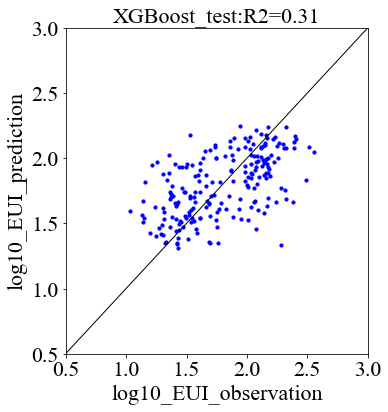

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(log_y.iloc[test], log_y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("XGBoost_test:R2=0.31", fontsize=22)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.show()
plt.close()

# Shaply Interpretation

In [59]:
import shap

In [60]:
y_pred_shap = xgb_model.predict(data_matrix,pred_contribs=True)

In [66]:
shap_value_dep = y_pred_shap[:,:-1]

In [84]:
X_name = ['log10_hotel_ker','log10_parking_ker','log10_food_ker','log10_office_ker','log10_retail_ker',
          'DNI','wind_speed_10m','CDH','log10_area','No_of_Stor','year_built',
          'retro_before_audit','retro_after_audit','log10_mtr_dist','is_commercial_land_use']

In [85]:
X_shap = []

In [87]:
for i in range(len(X_name)):
    X_shap.append(abs(shap_value_dep[:,i]).mean())

In [88]:
X_mean_shap = pd.DataFrame({'X_name':X_name,
                            'X_shap':X_shap})

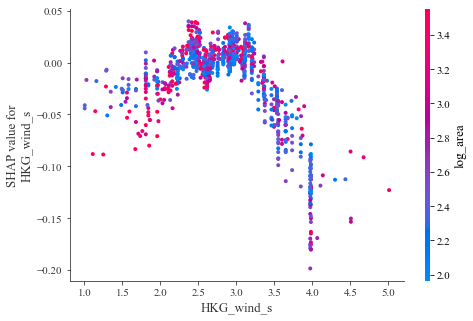

In [47]:
shap.dependence_plot("HKG_wind_s",shap_value_dep, X, interaction_index='log_area')